<a href="https://colab.research.google.com/github/jjasira/Stochastic-modeling/blob/main/GW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Data Preparation and Exploration**

In [ ]:
!pip -q install yfinance

In [ ]:
!pip -q install yfinance hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 7.9 MB/s eta 0:00:00


In [ ]:
import os, glob
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from numpy.linalg import eig
from hmmlearn.hmm import GaussianHMM

In [ ]:
ETF_TICKERS = ["TLT", "GLD", "SPY"]
VIX_TICKER = "^VIX"
USE_VIX_CHANGE = True

In [ ]:
all_tickers = ETF_TICKERS + [VIX_TICKER]
raw = yf.download(all_tickers, period="max", auto_adjust=False, progress=False)

In [ ]:
# Keep only Adjusted Close; handle multi-index columns returned by yfinance
if isinstance(raw.columns, pd.MultiIndex):
    adj = raw["Adj Close"].copy()
else:
    adj = raw[["Adj Close"]].copy()

In [ ]:
# Rename columns for cleanliness (drop level if present)
adj.columns.name = None
adj = adj.rename(columns={c: c for c in adj.columns})

# Drop rows where all are NaN (common at the very start)
adj = adj.dropna(how="all")

In [ ]:
# We need dates where all series are present (no NaNs)
adj_common = adj[all_tickers].dropna(how="any").copy()

# Separate ETFs and VIX for clarity
adj_etf = adj_common[ETF_TICKERS].copy()
adj_vix = adj_common[[VIX_TICKER]].copy()

In [ ]:
# Sanity check: report sample span after alignment
start_date = adj_common.index.min().date()
end_date   = adj_common.index.max().date()
print(f"Common sample period: {start_date} → {end_date}  (n={len(adj_common):,} trading days)")


Common sample period: 2004-11-18 → 2025-11-04  (n=5,274 trading days)


In [ ]:
# ----------------------------
# 3) Compute daily returns
# ----------------------------
# (a) ETFs — daily log-returns: r_t = ln(P_t / P_{t-1})
rets_etf = np.log(adj_etf / adj_etf.shift(1)).dropna()
rets_etf.columns = [f"{t}_logret" for t in rets_etf.columns]

# (b) VIX — both absolute change and log-return (you can choose later)
vix = adj_vix.rename(columns={VIX_TICKER: "VIX"})
vix_change = vix.diff().rename(columns={"VIX": "VIX_change"})           # absolute change
vix_logret = np.log(vix / vix.shift(1)).rename(columns={"VIX": "VIX_logret"})  # log-return
rets_vix = pd.concat([vix_change, vix_logret], axis=1).dropna()

In [ ]:
# ----------------------------
# 4) Combine outputs
# ----------------------------
# Keep aligned dates after differencing
returns = rets_etf.join(rets_vix, how="inner")

# Also keep a compact price frame aligned to the returns index, if needed later
prices = adj_common.loc[returns.index, ETF_TICKERS + [VIX_TICKER]].rename(columns={VIX_TICKER: "VIX"})


In [ ]:
# ----------------------------
# 5) Quick exploration
# ----------------------------
print("\nHead (prices):")
print(prices.head(3))
print("\nHead (returns):")
print(returns.head(3))

print("\nSummary stats (ETF log-returns):")
print(rets_etf.describe().T[["mean", "std", "min", "max"]])

print("\nSummary stats (VIX change & log-return):")
print(rets_vix.describe().T[["mean", "std", "min", "max"]])


Head (prices):
                  TLT        GLD        SPY    VIX
Date                                              
2004-11-19  44.795387  44.779999  79.512093  13.50
2004-11-22  45.028858  44.950001  79.891319  12.97
2004-11-23  45.084652  44.750000  80.013222  12.67

Head (returns):
            TLT_logret  GLD_logret  SPY_logret  VIX_change  VIX_logret
Date                                                                  
2004-11-19   -0.008012    0.008973   -0.011179        0.52    0.039280
2004-11-22    0.005198    0.003789    0.004758       -0.53   -0.040051
2004-11-23    0.001238   -0.004459    0.001525       -0.30   -0.023402

Summary stats (ETF log-returns):
                mean       std       min       max
TLT_logret  0.000131  0.009254 -0.069011  0.072503
GLD_logret  0.000398  0.011128 -0.091905  0.106974
SPY_logret  0.000404  0.012010 -0.115887  0.135577

Summary stats (VIX change & log-return):
                mean       std        min        max
VIX_change  0.001142  1.

In [ ]:
# 6) Save to CSV (handy for later steps / grading)
# ----------------------------
prices.to_csv("prices_common_sample.csv")
returns.to_csv("daily_returns.csv")

print("\nSaved files:")
print("- prices_common_sample.csv")
print("- daily_returns.csv")


Saved files:
- prices_common_sample.csv
- daily_returns.csv


In [ ]:
# ----------------------------
# Load from prior CSVs if available; otherwise fetch
# ----------------------------
prices_path = "prices_common_sample.csv"
returns_path = "daily_returns.csv"

if os.path.exists(prices_path) and os.path.exists(returns_path):
    prices = pd.read_csv(prices_path, index_col=0, parse_dates=True)
    returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
else:
    all_tickers = ETF_TICKERS + [VIX_TICKER]
    raw = yf.download(all_tickers, period="max", auto_adjust=False, progress=False)
    if isinstance(raw.columns, pd.MultiIndex):
        adj = raw["Adj Close"].copy()
    else:
        adj = raw[["Adj Close"]].copy()

    adj.columns.name = None
    adj = adj.dropna(how="all")
    adj_common = adj[all_tickers].dropna(how="any").copy()

    adj_etf = adj_common[ETF_TICKERS].copy()
    vix = adj_common[[VIX_TICKER]].copy().rename(columns={VIX_TICKER: "VIX"})

    rets_etf = np.log(adj_etf / adj_etf.shift(1)).dropna()
    rets_etf.columns = [f"{t}_logret" for t in rets_etf.columns]

    vix_change = vix.diff().rename(columns={"VIX": "VIX_change"})
    vix_logret = np.log(vix / vix.shift(1)).rename(columns={"VIX": "VIX_logret"})
    rets_vix = pd.concat([vix_change, vix_logret], axis=1).dropna()

    returns = rets_etf.join(rets_vix, how="inner")
    prices = adj_common.loc[returns.index, ETF_TICKERS + [VIX_TICKER]].rename(columns={VIX_TICKER: "VIX"})


In [ ]:
# ----------------------------
# Alignment & cleaning (defensive)
# ----------------------------
# Keep only dates where all ETF returns exist
etf_ret_cols = [f"{t}_logret" for t in ETF_TICKERS]
cols_needed = etf_ret_cols + ["VIX_change", "VIX_logret"]
returns = returns[cols_needed].dropna(how="any").copy()

# Align prices to cleaned returns dates
prices = prices.loc[returns.index].copy()

# Sanity checks
print(f"Cleaned sample: {returns.index.min().date()} → {returns.index.max().date()}  (n={len(returns):,})")
print("\nNull counts (should be zero):")
print(returns.isna().sum())



Cleaned sample: 2004-11-19 → 2025-11-04  (n=5,273)

Null counts (should be zero):
TLT_logret    0
GLD_logret    0
SPY_logret    0
VIX_change    0
VIX_logret    0
dtype: int64


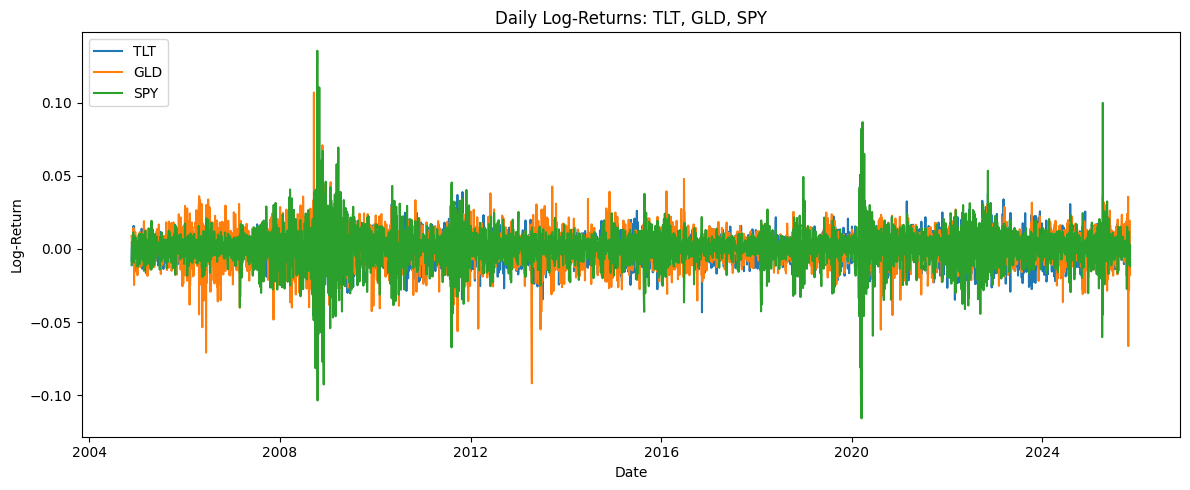

In [ ]:
# ----------------------------
# Plot 1: ETF returns (one figure, three lines)
# ----------------------------
plt.figure(figsize=(12, 5))
for c in etf_ret_cols:
    plt.plot(returns.index, returns[c], label=c.replace("_logret", ""))
plt.title("Daily Log-Returns: TLT, GLD, SPY")
plt.xlabel("Date")
plt.ylabel("Log-Return")
plt.legend()
plt.tight_layout()
plt.savefig("plot_etf_logreturns.png", dpi=150)
plt.show()



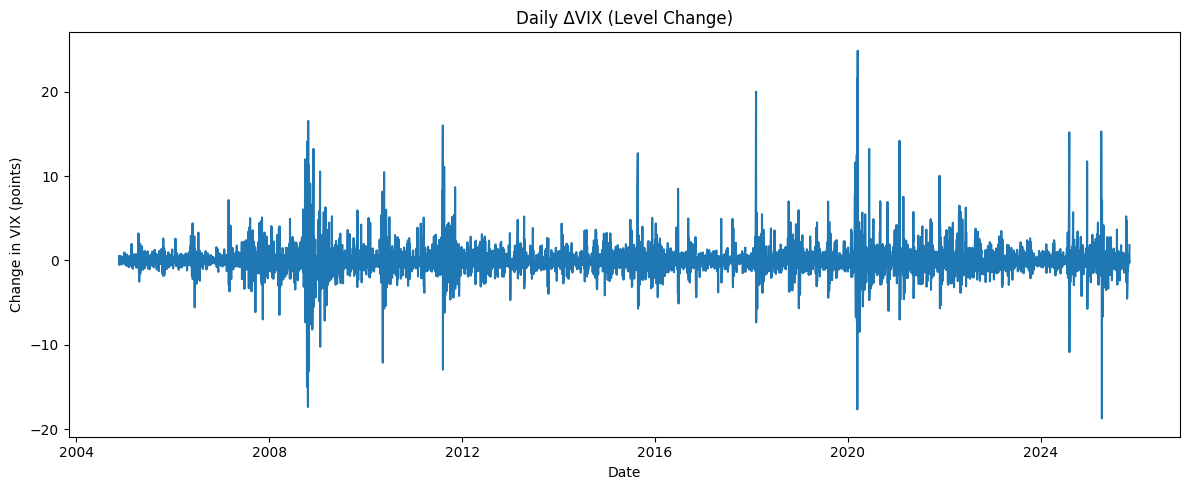

In [ ]:
# ----------------------------
# Plot 2: ΔVIX or VIX log-returns (one figure)
# ----------------------------
plt.figure(figsize=(12, 5))
if USE_VIX_CHANGE:
    plt.plot(returns.index, returns["VIX_change"])
    plt.title("Daily ΔVIX (Level Change)")
    plt.ylabel("Change in VIX (points)")
else:
    plt.plot(returns.index, returns["VIX_logret"])
    plt.title("Daily VIX Log-Return")
    plt.ylabel("Log-Return")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("plot_vix_series.png", dpi=150)
plt.show()



In [ ]:
# ----------------------------
# Save cleaned deliverables
# ----------------------------
prices.to_csv("prices_clean_aligned.csv")
returns.to_csv("returns_clean_aligned.csv")



# **Step 2: Modelling VIX Regimes**

In [ ]:
MC_NUM_STATES = 3         # Choose 2 or 3 for the discrete Markov chain option
RANDOM_SEED = 42          # for reproducibility

np.random.seed(RANDOM_SEED)

In [ ]:
# ----------------------------
# Load cleaned data if available; else fetch & prepare
# ----------------------------
def prepare_data():
    # If Step 1 outputs exist, reuse them
    if os.path.exists("prices_clean_aligned.csv") and os.path.exists("returns_clean_aligned.csv"):
        prices = pd.read_csv("prices_clean_aligned.csv", index_col=0, parse_dates=True)
        returns = pd.read_csv("returns_clean_aligned.csv", index_col=0, parse_dates=True)
        return prices, returns

    # Otherwise, fetch from Yahoo and compute
    all_tickers = ETF_TICKERS + [VIX_YF]
    raw = yf.download(all_tickers, period="max", auto_adjust=False, progress=False)
    if isinstance(raw.columns, pd.MultiIndex):
        adj = raw["Adj Close"].copy()
    else:
        adj = raw[["Adj Close"]].copy()
    adj.columns.name = None
    adj = adj.dropna(how="all")
    adj = adj[all_tickers].dropna(how="any").copy()

    # Split ETFs & VIX
    etf_prices = adj[ETF_TICKERS].copy()
    vix = adj[[VIX_YF]].rename(columns={VIX_YF: "VIX"})

    # ETF log-returns
    etf_logrets = np.log(etf_prices / etf_prices.shift(1)).dropna()
    etf_logrets.columns = [f"{t}_logret" for t in etf_logrets.columns]

    # VIX change & log-return
    vix_change = vix.diff().rename(columns={"VIX": "VIX_change"})
    vix_logret = np.log(vix / vix.shift(1)).rename(columns={"VIX": "VIX_logret"})
    vix_rets = pd.concat([vix_change, vix_logret], axis=1).dropna()

    returns = etf_logrets.join(vix_rets, how="inner")
    prices = adj.loc[returns.index, ETF_TICKERS + [VIX_YF]].rename(columns={VIX_YF: "VIX"})

    # Save for later steps
    prices.to_csv("prices_clean_aligned.csv")
    returns.to_csv("returns_clean_aligned.csv")
    return prices, returns

prices, returns = prepare_data()

# Pull the series we need
vix_level = prices["VIX"].copy()
dVIX = returns["VIX_change"].copy()    # ΔVIX (level change)
dVIX = dVIX.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure alignment between level and change (drop first NA in change)
common_idx = vix_level.index.intersection(dVIX.index)
vix_level = vix_level.loc[common_idx]
dVIX = dVIX.loc[common_idx]

print(f"Modeling sample: {dVIX.index.min().date()} → {dVIX.index.max().date()}  (n={len(dVIX):,})")



Modeling sample: 2004-11-19 → 2025-11-04  (n=5,273)



==== Discrete Markov Chain on ΔVIX ====
Number of states: 3
Transition counts:
        S0     S1     S2
S0  615.0  540.0  607.0
S1  413.0  761.0  588.0
S2  734.0  461.0  553.0

Transition matrix P (rows: from, cols: to):
           S0        S1        S2
S0  0.349035  0.306470  0.344495
S1  0.234393  0.431896  0.333712
S2  0.419908  0.263730  0.316362

Stationary distribution π:
 S0    0.334219
S1    0.334219
S2    0.331563
dtype: float64


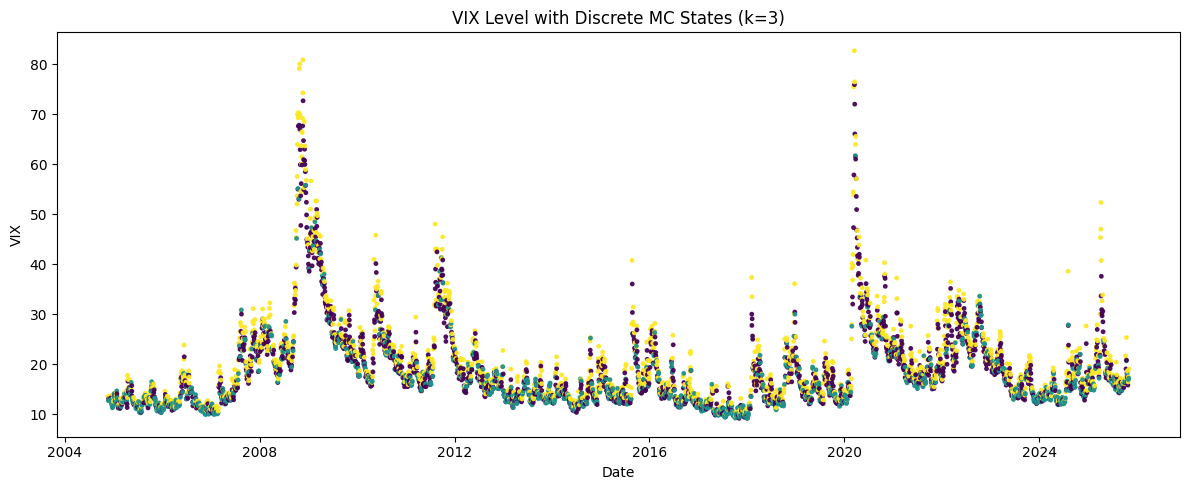

In [ ]:
# =================================================
# Part A: Discrete Markov Chain on ΔVIX (Quantiles)
# =================================================

def discretize_quantiles(series, k):
    """
    Discretize a series into k ordinal states by quantiles.
    Returns: state_labels (0..k-1), quantile_edges
    """
    # To avoid duplicate bin edges if flat regions exist, use rank-based quantiles
    try:
        cats = pd.qcut(series, q=k, labels=False, duplicates="drop")
        actual_k = len(pd.unique(cats.dropna()))
        if actual_k < k:
            print(f"Warning: Only {actual_k} distinct quantile bins found; proceeding with {actual_k} states.")
        return cats.astype(int), actual_k
    except ValueError:
        # In rare degenerate cases, fall back to k=2
        print("qcut failed; falling back to k=2.")
        cats = pd.qcut(series, q=2, labels=False, duplicates="drop")
        return cats.astype(int), 2

def estimate_transition_matrix(states, k):
    """
    Estimate a k x k transition matrix from integer-encoded states.
    """
    counts = np.zeros((k, k), dtype=float)
    for i in range(len(states) - 1):
        a, b = states[i], states[i + 1]
        counts[a, b] += 1.0
    # Row-normalize (handle zero rows safely)
    P = counts / counts.sum(axis=1, keepdims=True)
    P = np.nan_to_num(P)
    return P, counts

def stationary_distribution(P):
    """
    Compute stationary distribution π such that πP = π.
    Uses eigen-decomposition of P^T (eigenvalue 1).
    """
    w, v = eig(P.T)
    # Find eigenvector associated with eigenvalue closest to 1
    idx = np.argmin(np.abs(w - 1.0))
    vec = np.real(v[:, idx])
    pi = vec / vec.sum()
    pi = np.where(pi < 0, 0, pi)  # ensure non-negative
    pi = pi / pi.sum()            # renormalize
    return pi

# Discretize
mc_states_raw, k_mc = discretize_quantiles(dVIX, MC_NUM_STATES)
mc_states = mc_states_raw.values

# Transition matrix & stationary distribution
P_mc, N_counts = estimate_transition_matrix(mc_states, k_mc)
pi_mc = stationary_distribution(P_mc)

print("\n==== Discrete Markov Chain on ΔVIX ====")
print(f"Number of states: {k_mc}")
print("Transition counts:\n", pd.DataFrame(N_counts, index=[f"S{i}" for i in range(k_mc)],
                                           columns=[f"S{j}" for j in range(k_mc)]))
print("\nTransition matrix P (rows: from, cols: to):\n",
      pd.DataFrame(P_mc, index=[f"S{i}" for i in range(k_mc)],
                         columns=[f"S{j}" for j in range(k_mc)]))
print("\nStationary distribution π:\n",
      pd.Series(pi_mc, index=[f"S{i}" for i in range(k_mc)]))

# Plot: VIX level color-coded by MC state
plt.figure(figsize=(12, 5))
plt.scatter(vix_level.index, vix_level.values, c=mc_states, s=6, alpha=0.9)
plt.title(f"VIX Level with Discrete MC States (k={k_mc})")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.tight_layout()
plt.savefig("plot_vix_mc_states.png", dpi=150)
plt.show()

# Save MC artifacts
pd.DataFrame(P_mc, index=[f"S{i}" for i in range(k_mc)],
             columns=[f"S{j}" for j in range(k_mc)]).to_csv("mc_transition_matrix.csv")
pd.Series(pi_mc, index=[f"S{i}" for i in range(k_mc)]).to_csv("mc_stationary_distribution.csv")
pd.DataFrame({"date": vix_level.index, "VIX": vix_level.values, "mc_state": mc_states}).to_csv(
    "mc_state_series.csv", index=False
)


==== Gaussian HMM (2-state) ====
Start probabilities:
 S0    1.657172e-25
S1    1.000000e+00
dtype: float64
Transition matrix:
           S0        S1
S0  0.882275  0.117725
S1  0.040176  0.959824
State means (ΔVIX):
 S0    0.222016
S1   -0.074157
dtype: float64
State variances (ΔVIX):
 S0    12.375675
S1     0.661541
dtype: float64

==== Gaussian HMM (3-state) ====
Start probabilities:
 S0     1.196500e-89
S1    9.133059e-133
S2     1.000000e+00
dtype: float64
Transition matrix:
           S0        S1            S2
S0  0.911234  0.017066  7.170031e-02
S1  0.125865  0.874135  7.112926e-11
S2  0.059506  0.001181  9.393129e-01
State means (ΔVIX):
 S0   -0.017843
S1    0.620350
S2   -0.059380
dtype: float64
State variances (ΔVIX):
 S0     2.927009
S1    34.805344
S2     0.370301
dtype: float64


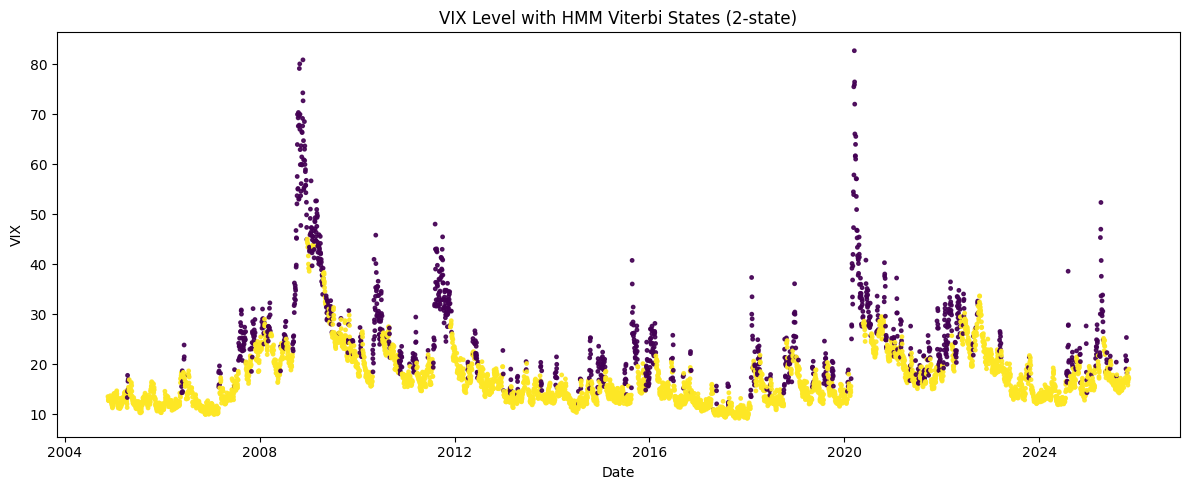

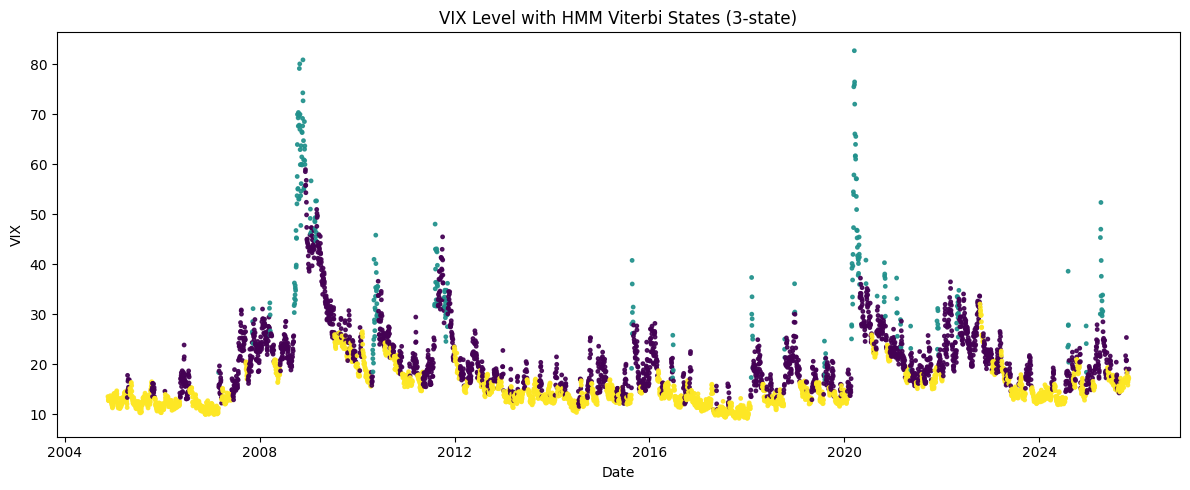

In [ ]:
# =============================================
# Part B: Hidden Markov Models on ΔVIX (Gaussian)
# =============================================

def fit_gaussian_hmm(series, n_states, n_iter=200, seed=RANDOM_SEED):
    """
    Fit a GaussianHMM to ΔVIX (1-D).
    Returns: model, viterbi_states, smoothed_probs (T x n_states)
    """
    X = series.values.reshape(-1, 1)
    model = GaussianHMM(n_components=n_states, covariance_type="full",
                        n_iter=n_iter, random_state=seed, verbose=False)
    model.fit(X)
    viterbi = model.predict(X)
    # Smoothed posteriors (gamma): use score_samples
    _, post = model.score_samples(X)
    return model, viterbi, post

def summarize_hmm(model, label):
    means = model.means_.ravel()
    # covars_ may be full matrices; convert to variances
    if model.covariance_type == "full":
        vars_ = np.array([np.diag(c)[0] for c in model.covars_])
    elif model.covariance_type == "diag":
        vars_ = model.covars_.ravel()
    else:
        vars_ = np.array(model.covars_).ravel()

    print(f"\n==== Gaussian HMM ({label}) ====")
    print("Start probabilities:\n", pd.Series(model.startprob_, index=[f"S{i}" for i in range(model.n_components)]))
    print("Transition matrix:\n", pd.DataFrame(model.transmat_,
                                               index=[f"S{i}" for i in range(model.n_components)],
                                               columns=[f"S{j}" for j in range(model.n_components)]))
    print("State means (ΔVIX):\n", pd.Series(means, index=[f"S{i}" for i in range(model.n_components)]))
    print("State variances (ΔVIX):\n", pd.Series(vars_, index=[f"S{i}" for i in range(model.n_components)]))

# Fit HMM-2 and HMM-3
hmm2, v2, post2 = fit_gaussian_hmm(dVIX, n_states=2)
hmm3, v3, post3 = fit_gaussian_hmm(dVIX, n_states=3)

summarize_hmm(hmm2, "2-state")
summarize_hmm(hmm3, "3-state")

# Plot: VIX level color-coded by HMM-2 Viterbi states
plt.figure(figsize=(12, 5))
plt.scatter(vix_level.index, vix_level.values, c=v2, s=6, alpha=0.9)
plt.title("VIX Level with HMM Viterbi States (2-state)")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.tight_layout()
plt.savefig("plot_vix_hmm2_states.png", dpi=150)
plt.show()

# Plot: VIX level color-coded by HMM-3 Viterbi states
plt.figure(figsize=(12, 5))
plt.scatter(vix_level.index, vix_level.values, c=v3, s=6, alpha=0.9)
plt.title("VIX Level with HMM Viterbi States (3-state)")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.tight_layout()
plt.savefig("plot_vix_hmm3_states.png", dpi=150)
plt.show()

# Save HMM artifacts
# 2-state
pd.DataFrame(hmm2.transmat_, index=[f"S{i}" for i in range(2)],
             columns=[f"S{j}" for j in range(2)]).to_csv("hmm2_transmat.csv")
pd.Series(hmm2.startprob_, index=[f"S{i}" for i in range(2)]).to_csv("hmm2_startprob.csv")
pd.Series(hmm2.means_.ravel(), index=[f"S{i}" for i in range(2)]).to_csv("hmm2_means.csv")
# Variances
if hmm2.covariance_type == "full":
    h2_vars = pd.Series([np.diag(c)[0] for c in hmm2.covars_], index=[f"S{i}" for i in range(2)])
elif hmm2.covariance_type == "diag":
    h2_vars = pd.Series(hmm2.covars_.ravel(), index=[f"S{i}" for i in range(2)])
else:
    h2_vars = pd.Series(np.array(hmm2.covars_).ravel(), index=[f"S{i}" for i in range(2)])
h2_vars.to_csv("hmm2_vars.csv")
pd.DataFrame({"date": vix_level.index, "VIX": vix_level.values, "hmm2_state": v2}).to_csv("hmm2_state_series.csv", index=False)
pd.DataFrame(post2, columns=[f"S{i}_prob" for i in range(2)], index=vix_level.index).to_csv("hmm2_smoothed_probs.csv")

# 3-state
pd.DataFrame(hmm3.transmat_, index=[f"S{i}" for i in range(3)],
             columns=[f"S{j}" for j in range(3)]).to_csv("hmm3_transmat.csv")
pd.Series(hmm3.startprob_, index=[f"S{i}" for i in range(3)]).to_csv("hmm3_startprob.csv")
pd.Series(hmm3.means_.ravel(), index=[f"S{i}" for i in range(3)]).to_csv("hmm3_means.csv")
# Variances
if hmm3.covariance_type == "full":
    h3_vars = pd.Series([np.diag(c)[0] for c in hmm3.covars_], index=[f"S{i}" for i in range(3)])
elif hmm3.covariance_type == "diag":
    h3_vars = pd.Series(hmm3.covars_.ravel(), index=[f"S{i}" for i in range(3)])
else:
    h3_vars = pd.Series(np.array(hmm3.covars_).ravel(), index=[f"S{i}" for i in range(3)])
h3_vars.to_csv("hmm3_vars.csv")
pd.DataFrame({"date": vix_level.index, "VIX": vix_level.values, "hmm3_state": v3}).to_csv("hmm3_state_series.csv", index=False)
pd.DataFrame(post3, columns=[f"S{i}_prob" for i in range(3)], index=vix_level.index).to_csv("hmm3_smoothed_probs.csv")


# **Step 3 : State Selection and Interpretation**


==== Model Comparison Table ====
  Method  #States       LogLik           AIC           BIC
2     MC        3 -5703.991114  11419.982228  11459.404356
1    HMM        3 -8623.687391  17275.374782  17367.359749
0    HMM        2 -8967.231454  17948.462908  17994.455391

==== State-Conditional Means ====
       TLT_logret  GLD_logret  SPY_logret  VIX_logret
state                                                
0.0      0.000236    0.000322    0.000011    0.000788
1.0      0.001673    0.000476   -0.004749    0.022915
2.0     -0.000127    0.000454    0.001299   -0.003028

==== State-Conditional Std Dev ====
       TLT_logret  GLD_logret  SPY_logret  VIX_logret
state                                                
0.0      0.009660    0.011423    0.012093    0.084117
1.0      0.017325    0.020023    0.033809    0.173711
2.0      0.007450    0.009387    0.005493    0.042431


<Figure size 1000x600 with 0 Axes>

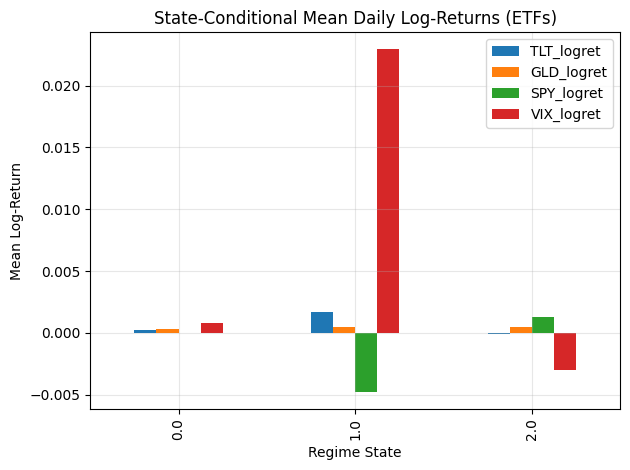


Saved outputs:
- model_comparison.csv
- state_means.csv
- state_stds.csv
- plot_state_mean_returns.png
- hmm3_state_series_chosen.csv


In [ ]:
# ----------------------------
# Load data prepared in Steps 1–2
# ----------------------------
returns = pd.read_csv("returns_clean_aligned.csv", index_col=0, parse_dates=True)

# ΔVIX (level change) for regime modeling
dVIX = returns["VIX_change"].dropna().values.reshape(-1, 1)
T = dVIX.shape[0]

# Optional MC artifacts from Step 2 (only used if present)
mc_trans_path = "mc_transition_matrix.csv"
mc_states_path = "mc_state_series.csv"
mc_available = os.path.exists(mc_trans_path) and os.path.exists(mc_states_path)

# ----------------------------
# Utility: parameter count for 1-D Gaussian HMM with full covariance
# n: #states, d: dimension (=1 here)
# params = (n-1) start probs + n(n-1) transitions + n*d means + n * d(d+1)/2 covars
# For d=1: params = (n-1) + n(n-1) + n + n = n^2 + 2n - 1
# ----------------------------
def num_params_gaussian_hmm_full(n, d=1):
    return (n - 1) + n * (n - 1) + n * d + n * (d * (d + 1) // 2)

# ----------------------------
# Fit HMM(2) and HMM(3) properly (EM)
# ----------------------------
SEED = 42
N_ITER = 200

hmm2 = GaussianHMM(n_components=2, covariance_type="full", n_iter=N_ITER, random_state=SEED)
hmm2.fit(dVIX)
ll2 = hmm2.score(dVIX)
k2 = num_params_gaussian_hmm_full(2, d=1)
aic2 = 2 * k2 - 2 * ll2
bic2 = np.log(T) * k2 - 2 * ll2
v2 = hmm2.predict(dVIX)  # Viterbi

hmm3 = GaussianHMM(n_components=3, covariance_type="full", n_iter=N_ITER, random_state=SEED)
hmm3.fit(dVIX)
ll3 = hmm3.score(dVIX)
k3 = num_params_gaussian_hmm_full(3, d=1)
aic3 = 2 * k3 - 2 * ll3
bic3 = np.log(T) * k3 - 2 * ll3
v3 = hmm3.predict(dVIX)

# ----------------------------
# If MC is available, compute pseudo-LL and pseudo-AIC/BIC (for comparison only)
# Note: MC has no emission density; we approximate via transition likelihood.
# ----------------------------
comparison_rows = []
comparison_rows.append(["HMM", 2, ll2, aic2, bic2])
comparison_rows.append(["HMM", 3, ll3, aic3, bic3])

if mc_available:
    P_mc = pd.read_csv(mc_trans_path, index_col=0).values
    mc_states_df = pd.read_csv(mc_states_path, parse_dates=["date"])
    mc_states = mc_states_df["mc_state"].values.astype(int)
    # pseudo log-likelihood from transitions
    eps = 1e-12
    logP = np.log(P_mc + eps)
    ll_mc = 0.0
    for i in range(len(mc_states) - 1):
        ll_mc += logP[mc_states[i], mc_states[i + 1]]
    # free params in k-state transition matrix: k*(k-1)
    k_mc = P_mc.shape[0]
    p_mc = k_mc * (k_mc - 1)
    aic_mc = 2 * p_mc - 2 * ll_mc
    bic_mc = np.log(len(mc_states)) * p_mc - 2 * ll_mc
    comparison_rows.append(["MC", k_mc, ll_mc, aic_mc, bic_mc])

comparison_df = pd.DataFrame(comparison_rows, columns=["Method", "#States", "LogLik", "AIC", "BIC"])
print("\n==== Model Comparison Table ====")
print(comparison_df.sort_values(["BIC", "AIC"]))

comparison_df.to_csv("model_comparison.csv", index=False)

# ----------------------------
# SELECT your preferred model here
# Options: "hmm2", "hmm3", "mc"
# ----------------------------
SELECTED = "hmm3"  # <=== adjust for your write-up after reviewing AIC/BIC + interpretability

# Build state series (date index aligned with returns/dVIX)
state_series = pd.Series(index=returns["VIX_change"].dropna().index, dtype=int, name="state")

if SELECTED == "hmm2":
    state_series[:] = v2
elif SELECTED == "hmm3":
    state_series[:] = v3
elif SELECTED == "mc" and mc_available:
    mc_states_df = mc_states_df.set_index("date").reindex(state_series.index).dropna()
    state_series = mc_states_df["mc_state"].astype(int)
else:
    raise ValueError("Invalid SELECTED model or MC artifacts not available.")

# ----------------------------
# State-conditional stats for ETFs
# ----------------------------
etf_cols = [c for c in returns.columns if c.endswith("_logret")]  # TLT_logret, GLD_logret, SPY_logret
aligned = returns.loc[state_series.index, etf_cols].copy()
aligned["state"] = state_series.values

mean_by_state = aligned.groupby("state")[etf_cols].mean()
std_by_state = aligned.groupby("state")[etf_cols].std()

print("\n==== State-Conditional Means ====")
print(mean_by_state)
print("\n==== State-Conditional Std Dev ====")
print(std_by_state)

mean_by_state.to_csv("state_means.csv")
std_by_state.to_csv("state_stds.csv")

# ----------------------------
# Plot: Bar chart of mean returns by state (deliverable)
# ----------------------------
plt.figure(figsize=(10, 6))
mean_by_state.plot(kind="bar")
plt.title("State-Conditional Mean Daily Log-Returns (ETFs)")
plt.xlabel("Regime State")
plt.ylabel("Mean Log-Return")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plot_state_mean_returns.png", dpi=150)
plt.show()

print("\nSaved outputs:")
print("- model_comparison.csv")
print("- state_means.csv")
print("- state_stds.csv")
print("- plot_state_mean_returns.png")

# ----------------------------
# Optional: also save Viterbi state series for the chosen model
# ----------------------------
out = pd.DataFrame({"date": state_series.index, "state": state_series.values})
out.to_csv(f"{SELECTED}_state_series_chosen.csv", index=False)
print(f"- {SELECTED}_state_series_chosen.csv")

# **Step 4: Designing  the Ratation Strategy**

=== State → Allocation Mapping ===
       TLT_logret  GLD_logret  SPY_logret  VIX_logret decision_rule
state                                                              
0.0           0.0         0.0         0.0         1.0      100% VIX
1.0           0.0         0.0         0.0         1.0      100% VIX
2.0           0.0         0.0         1.0         0.0      100% SPY


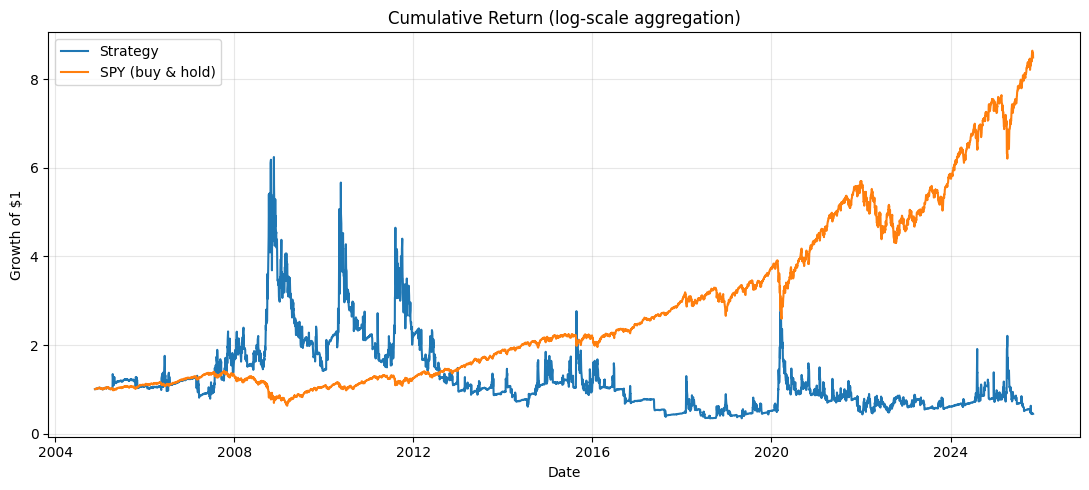


Saved files:
- state_allocation_mapping.csv  (the decision table)
- daily_portfolio_weights.csv   (date-indexed weights per ETF)
- daily_strategy_and_benchmark_returns.csv
- plot_cumulative_performance.png  (optional)


In [ ]:
# ----------------------------
# Config
# ----------------------------
USE_60_40 = False   # True -> 60/40 between top two ETFs; False -> 100% to top ETF
EXECUTION_LAG_DAYS = 1  # 0 -> no lag (in-sample), 1 -> one-day lag to avoid lookahead bias

# ----------------------------
# Load inputs from prior steps
# ----------------------------
returns = pd.read_csv("returns_clean_aligned.csv", index_col=0, parse_dates=True)
state_means = pd.read_csv("state_means.csv", index_col=0)  # from Step 3

# Pick the chosen state sequence file saved in Step 3:
# e.g., "hmm3_state_series_chosen.csv" or "hmm2_state_series_chosen.csv" or "mc_state_series_chosen.csv"
candidates = glob.glob("*_state_series_chosen.csv")
if not candidates:
    raise FileNotFoundError(
        "Could not find *_state_series_chosen.csv. "
        "Run Step 3 (fixed) and ensure it saves the chosen state series."
    )
state_file = candidates[0]  # if more than one exists, take the first; adjust as needed
state_df = pd.read_csv(state_file, parse_dates=["date"]).set_index("date").sort_index()
state_series = state_df["state"].astype(int)

# Align to returns index and apply optional execution lag to avoid lookahead
state_series = state_series.reindex(returns.index).dropna().astype(int)
if EXECUTION_LAG_DAYS > 0:
    state_series = state_series.shift(EXECUTION_LAG_DAYS)

# Drop the initial rows lost due to lag or NA alignment
valid_idx = state_series.dropna().index
state_series = state_series.loc[valid_idx]
returns = returns.loc[valid_idx]

# ----------------------------
# Build the decision rule from state-conditional historical means
# ----------------------------
# state_means rows: states; columns: TLT_logret, GLD_logret, SPY_logret
etf_cols = [c for c in state_means.columns if c.endswith("_logret")]
if not etf_cols:
    raise ValueError("No ETF log-return columns found in state_means.csv")

# For readability, create a tidy mapping table
mapping_rows = []
for s in state_means.index:
    row = state_means.loc[s, etf_cols].copy()
    # Rank ETFs by mean return in descending order
    top_list = row.sort_values(ascending=False).index.tolist()
    top1 = top_list[0]
    top2 = top_list[1] if len(top_list) > 1 else None

    if USE_60_40 and top2 is not None:
        alloc = {etf: 0.0 for etf in etf_cols}
        alloc[top1] = 0.60
        alloc[top2] = 0.40
        decision = f"60/40 between {top1.replace('_logret','')} and {top2.replace('_logret','')}"
    else:
        alloc = {etf: 0.0 for etf in etf_cols}
        alloc[top1] = 1.00
        decision = f"100% {top1.replace('_logret','')}"

    mapping_rows.append({
        "state": s,
        **alloc,
        "decision_rule": decision
    })

mapping_df = pd.DataFrame(mapping_rows).set_index("state").sort_index()

# Save the mapping table
mapping_df.to_csv("state_allocation_mapping.csv")

print("=== State → Allocation Mapping ===")
print(mapping_df)

# ----------------------------
# Build daily portfolio weights from the mapping
# ----------------------------
# Create a weights DataFrame indexed by dates with ETF columns
weights = pd.DataFrame(0.0, index=state_series.index, columns=etf_cols)

# For each state, fill in the corresponding rows with the mapping weights
for s in mapping_df.index:
    subset_idx = state_series[state_series == s].index
    for c in etf_cols:
        weights.loc[subset_idx, c] = mapping_df.loc[s, c]

# Normalize any slight numeric drift
weights = weights.div(weights.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

# ----------------------------
# Compute strategy daily returns (log-returns)
# ----------------------------
etf_returns = returns[etf_cols].copy()
strategy_logret = (weights.values * etf_returns.values).sum(axis=1)
strategy_logret = pd.Series(strategy_logret, index=weights.index, name="strategy_logret")

# Optional benchmarks for context (not required by deliverable)
spy_logret = returns["SPY_logret"].reindex(strategy_logret.index)

# Save daily signals & returns
weights.to_csv("daily_portfolio_weights.csv")
pd.DataFrame({
    "strategy_logret": strategy_logret,
    "SPY_logret": spy_logret
}, index=strategy_logret.index).to_csv("daily_strategy_and_benchmark_returns.csv")

# ----------------------------
# Optional quick plot: cumulative performance vs SPY (sanity check)
# ----------------------------
try:
    cum_strategy = np.exp(strategy_logret.cumsum())
    cum_spy = np.exp(spy_logret.cumsum())
    plt.figure(figsize=(11,5))
    plt.plot(cum_strategy.index, cum_strategy, label="Strategy")
    plt.plot(cum_spy.index, cum_spy, label="SPY (buy & hold)")
    plt.title("Cumulative Return (log-scale aggregation)")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("plot_cumulative_performance.png", dpi=150)
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

print("\nSaved files:")
print("- state_allocation_mapping.csv  (the decision table)")
print("- daily_portfolio_weights.csv   (date-indexed weights per ETF)")
print("- daily_strategy_and_benchmark_returns.csv")
print("- plot_cumulative_performance.png  (optional)")

# **Step 5: Backtesting and Evaluation**


==== Performance Summary ====
                   Cumulative Return  Annualized Return  \
Strategy                   -0.553770          -0.037836   
EW (1/3, monthly)           5.123485           0.090481   
SPY (buy & hold)            7.492293           0.107662   

                   Annualized Volatility  Sharpe (rf=0)  Max Drawdown  
Strategy                        1.107270       0.474957     -0.944879  
EW (1/3, monthly)               0.095541       0.954543     -0.229496  
SPY (buy & hold)                0.190528       0.632104     -0.551894  


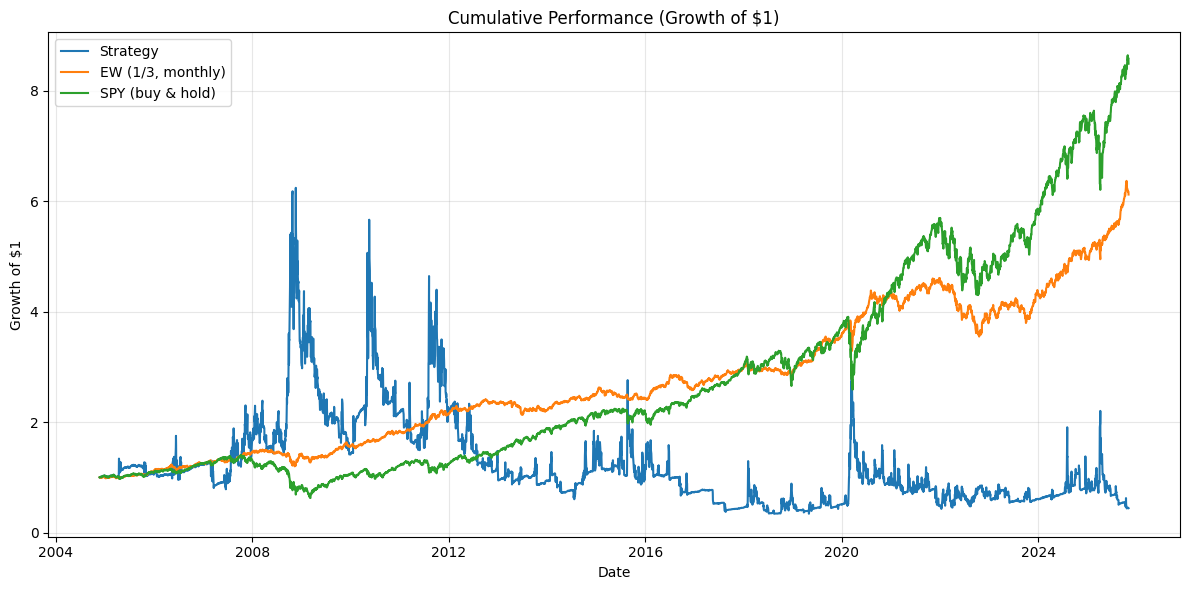


Saved outputs:
- performance_summary.csv
- plot_cumulative_performance_comparison.png

SENSITIVITY NOTES (for your write-up):
* If HMM states increase from 2 → 3, regimes often split the high-vol bucket, changing TLT/GLD preference and turnover.
* Shorter sample windows can overfit regime boundaries; consider rolling refits or an expanding window.
* Using ΔVIX vs. VIX log-returns may shift state cutoffs; re-run Step 2 with both and compare BIC.
* Results are sensitive to the 1-day lag; removing the lag improves in-sample but inflates lookahead bias.


In [ ]:
# ----------------------------
# Helpers
# ----------------------------
TRADING_DAYS = 252

def to_simple(logret: pd.Series) -> pd.Series:
    return np.exp(logret) - 1.0

def to_log(simple: pd.Series) -> pd.Series:
    return np.log1p(simple)

def equity_curve_from_logrets(logrets: pd.Series) -> pd.Series:
    return np.exp(logrets.cumsum())

def max_drawdown(equity: pd.Series) -> float:
    roll_max = equity.cummax()
    dd = (equity / roll_max) - 1.0
    return dd.min()

def perf_metrics_from_logrets(name: str, logrets: pd.Series) -> pd.Series:
    logrets = logrets.dropna()
    simple = to_simple(logrets)
    cum_ret = np.exp(logrets.sum()) - 1.0
    ann_ret = np.exp(logrets.mean() * TRADING_DAYS) - 1.0
    ann_vol = simple.std(ddof=1) * np.sqrt(TRADING_DAYS)
    sharpe = 0.0 if ann_vol == 0 else (simple.mean() / simple.std(ddof=1)) * np.sqrt(TRADING_DAYS)
    eq = equity_curve_from_logrets(logrets)
    mdd = max_drawdown(eq)
    return pd.Series({
        "Cumulative Return": cum_ret,
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe (rf=0)": sharpe,
        "Max Drawdown": mdd
    }, name=name)

def simulate_equal_weight_monthly(simple_rets: pd.DataFrame) -> pd.Series:
    """
    Simulate equal-weight (1/3 each) portfolio, rebalanced at the FIRST trading day of each month.
    Works with daily simple returns. Returns daily log-returns of the portfolio.
    """
    simple_rets = simple_rets.dropna(how="any").copy()
    idx = simple_rets.index
    target_w = np.full(simple_rets.shape[1], 1.0 / simple_rets.shape[1])

    # Identify first trading day of each month
    month_keys = pd.Index([f"{d.year}-{d.month:02d}" for d in idx])
    first_of_month = idx[~month_keys.duplicated(keep="first")]
    first_mask = pd.Series(False, index=idx)
    first_mask.loc[first_of_month] = True

    port_val = 1.0
    w = target_w.copy()
    port_logrets = []

    for t, date in enumerate(idx):
        r_t = simple_rets.iloc[t].values  # simple returns vector
        # Portfolio simple return for the day
        port_simple = float(np.dot(w, r_t))
        # Update portfolio value
        port_val *= (1.0 + port_simple)
        port_logrets.append(np.log1p(port_simple))

        # Drift weights with asset returns
        numer = w * (1.0 + r_t)
        denom = (1.0 + port_simple)
        if denom == 0:
            # Degenerate case; keep weights unchanged
            pass
        else:
            w = numer / denom

        # If this is the first trading day of a new month, rebalance at the close
        if first_mask.iloc[t]:
            w = target_w.copy()

    return pd.Series(port_logrets, index=idx, name="EW_monthly_logret")

# ----------------------------
# Load strategy & returns
# ----------------------------
# From Step 4:
if not os.path.exists("daily_strategy_and_benchmark_returns.csv"):
    raise FileNotFoundError("Run Step 4 first to create 'daily_strategy_and_benchmark_returns.csv'.")

df_sr = pd.read_csv("daily_strategy_and_benchmark_returns.csv", index_col=0, parse_dates=True)

# Also load raw ETF log-returns to build the equal-weight monthly benchmark
rets = pd.read_csv("returns_clean_aligned.csv", index_col=0, parse_dates=True)
etf_cols = [c for c in rets.columns if c.endswith("_logret")]
if not set(["TLT_logret", "GLD_logret", "SPY_logret"]).issubset(etf_cols):
    raise ValueError("ETF log-return columns not found. Re-run Step 1 to regenerate returns_clean_aligned.csv.")

# Ensure aligned index across all series
common_idx = df_sr.index.intersection(rets.index)
df_sr = df_sr.loc[common_idx].copy()
rets = rets.loc[common_idx].copy()

# Strategy (already 1-day lag applied in Step 4)
strategy_logret = df_sr["strategy_logret"].dropna()

# Buy-and-hold SPY (log returns)
spy_logret = df_sr["SPY_logret"].dropna()

# Equal-weight monthly, from simple ETF returns
etf_simple = to_simple(rets[["TLT_logret", "GLD_logret", "SPY_logret"]])
ew_monthly_logret = simulate_equal_weight_monthly(etf_simple).reindex(common_idx)

# ----------------------------
# Build comparison DataFrame
# ----------------------------
perf_series = {
    "Strategy": strategy_logret,
    "EW (1/3, monthly)": ew_monthly_logret,
    "SPY (buy & hold)": spy_logret
}

# Align again just in case
common_idx = strategy_logret.index.intersection(ew_monthly_logret.index).intersection(spy_logret.index)
for k in perf_series:
    perf_series[k] = perf_series[k].loc[common_idx]

# ----------------------------
# Metrics table
# ----------------------------
metrics = pd.concat([perf_metrics_from_logrets(k, s) for k, s in perf_series.items()], axis=1).T
metrics = metrics[["Cumulative Return", "Annualized Return", "Annualized Volatility", "Sharpe (rf=0)", "Max Drawdown"]]
print("\n==== Performance Summary ====")
print(metrics)

metrics.to_csv("performance_summary.csv")

# ----------------------------
# Plot cumulative performance curves
# ----------------------------
plt.figure(figsize=(12,6))
for k, s in perf_series.items():
    eq = equity_curve_from_logrets(s.loc[common_idx])
    plt.plot(eq.index, eq, label=k)
plt.title("Cumulative Performance (Growth of $1)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plot_cumulative_performance_comparison.png", dpi=150)
plt.show()

print("\nSaved outputs:")
print("- performance_summary.csv")
print("- plot_cumulative_performance_comparison.png")

# ----------------------------
# Brief sensitivity notes (printed for report)
# ----------------------------
print("\nSENSITIVITY NOTES (for your write-up):")
print("* If HMM states increase from 2 → 3, regimes often split the high-vol bucket, changing TLT/GLD preference and turnover.")
print("* Shorter sample windows can overfit regime boundaries; consider rolling refits or an expanding window.")
print("* Using ΔVIX vs. VIX log-returns may shift state cutoffs; re-run Step 2 with both and compare BIC.")
print("* Results are sensitive to the 1-day lag; removing the lag improves in-sample but inflates lookahead bias.")